In [1]:
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from string import punctuation
import pandas as pd

In [2]:
# Load data and set labels
data = pd.read_csv("../input/en-spanish/data.csv")

# Display dimensions of dataframe
print(data.shape)
print(data.info())

print("-----------------------------------------------------------------------")
# Display 10 random samples
print(data.head())

(118964, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118964 entries, 0 to 118963
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  118964 non-null  object
 1   spanish  118964 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None
-----------------------------------------------------------------------
  english  spanish
0     Go.      Ve.
1     Go.    Vete.
2     Go.    Vaya.
3     Go.  Váyase.
4     Hi.    Hola.


In [4]:
# Clean the string
def clean_string(string):
    # Replace no-break space with space
    string = string.replace("\u202f"," ")
    # Converts all uppercase characters into lowercase characters
    string = string.lower()

    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")

    # Eliminate duplicate whitespaces using wildcards   
    string = re.sub("\s+"," ", string)
    # Remove spaces at the beginning and at the end of the string
    string = string.strip()
           
    return string

#-------------------------------------------------------------------------------
# object to string
data["english"] = data["english"].astype(str)
data["spanish"]  = data["spanish"].astype(str)

# Clean the sentences
data["english"] = data["english"].apply(lambda x: clean_string(x))
data["spanish"]  = data["spanish"].apply(lambda x: clean_string(x))

print("Done ...")

Done ...


In [5]:
# Get the raw data
raw_data_en = data["english"].values
raw_data_fr = data["spanish"].values

# Add start and end
raw_data_fr_in_out = ["[start] " + st + " [end]" for st in raw_data_fr]

for _ in range(5):
    print(random.choice(raw_data_fr_in_out))

print("\n---------------------------------------------------------------------")
# Each line contains an English sentence and its corresponding French sentence. 
# The English sentence is the source sequence and the French one is the target sequence.
my_data = []
for i in range(len(raw_data_en)):
    en = raw_data_en[i]
    fr = raw_data_fr_in_out[i]
    my_data.append((en, fr))

my_data[:5]

[start] ¿me vende su casa [end]
[start] si me compras un helado te doy un beso [end]
[start] hice que mi perro se acueste [end]
[start] cuenta conmigo [end]
[start] no me agrada ese chico gordo que se comió tu almuerzo [end]

---------------------------------------------------------------------


[('go', '[start] ve [end]'),
 ('go', '[start] vete [end]'),
 ('go', '[start] vaya [end]'),
 ('go', '[start] váyase [end]'),
 ('hi', '[start] hola [end]')]

In [6]:
# Shuffle data
random.shuffle(my_data)

# Train_set = 80%, Test_set = 10%, Val_set = 10%
num_val_samples = int(0.1 * len(my_data))
num_train_samples = len(my_data) - 2 * num_val_samples

train_pairs = my_data[:num_train_samples]
val_pairs   = my_data[num_train_samples : num_train_samples + num_val_samples]
test_pairs  = my_data[num_train_samples + num_val_samples :]

print("Total pairs in my dtat : ",len(my_data))
print("Training pairs         : ",len(train_pairs))
print("Validation pairs       : ",len(val_pairs))
print("Test pairs             : ",len(test_pairs))

Total pairs in my dtat :  118964
Training pairs         :  95172
Validation pairs       :  11896
Test pairs             :  11896


In [7]:
# Vectorizing the text data
vocab_size      = 15000
sequence_length = 25
batch_size      = 64

en_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", 
    output_sequence_length = sequence_length,)

fr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,)

train_en_texts = [pair[0] for pair in train_pairs]
train_fr_texts = [pair[1] for pair in train_pairs]

en_vectorization.adapt(train_en_texts)
fr_vectorization.adapt(train_fr_texts)
 
print("Done ...")

Done ...


In [8]:
def format_dataset(en, fr):
    en = en_vectorization(en)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": en, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])

def make_dataset(pairs):
    en_texts, fr_texts = zip(*pairs)

    en_texts = list(en_texts)
    fr_texts = list(fr_texts)

    dataset = tf.data.Dataset.from_tensor_slices((en_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(1024).prefetch(32).cache()


train_dataset = make_dataset(train_pairs)
val_dataset   = make_dataset(val_pairs)

for inputs, targets in train_dataset.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 25)
inputs["decoder_inputs"].shape: (64, 25)
targets.shape: (64, 25)


In [9]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
         #-----------------------------------------------------------------------
        self.sequence_length = sequence_length
        self.vocab_size      = vocab_size
        self.embed_dim       = embed_dim

        #-----------------------------------------------------------------------
        # L3
        self.input_embeddings = layers.Embedding(
                                     input_dim=vocab_size, output_dim=embed_dim)
        
        #-----------------------------------------------------------------------
        # L4
        self.positional_encoding = layers.Embedding(
                                input_dim=sequence_length, output_dim=embed_dim)
       
    #---------------------------------------------------------------------------
    def call(self, inputs):
        length    = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        # L3
        embedded_inputs    = self.input_embeddings(inputs)
        # L4
        embedded_positions = self.positional_encoding(positions)
        # L5
        return embedded_inputs + embedded_positions

    #---------------------------------------------------------------------------
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
        
#*******************************************************************************
print("Done ...")

Done ...


In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        #-----------------------------------------------------------------------
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # L6
        self.attention = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        # L8
        self.feed_forward = keras.Sequential([
                                  layers.Dense(dense_dim, activation="relu"), 
                                   layers.Dense(embed_dim),])
        
        # L7
        self.normalization_1  = layers.LayerNormalization()
        # L9
        self.normalization_2  = layers.LayerNormalization()
        self.supports_masking = True

    #---------------------------------------------------------------------------
    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

        #-----------------------------------------------------------------------
        # L6
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        
        #-----------------------------------------------------------------------
        # L7
        addnorm_output_1 = self.normalization_1(inputs + attention_output)
        # L8
        feedforward_output = self.feed_forward(addnorm_output_1)
        # L9
        addnorm_output_2 = self.normalization_2(addnorm_output_1 + feedforward_output)
        # L10
        return addnorm_output_2

#*******************************************************************************
print("Done ...")

Done ...


In [11]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        #-----------------------------------------------------------------------
        self.embed_dim  = embed_dim
        self.latent_dim = latent_dim
        self.num_heads  = num_heads

        #-----------------------------------------------------------------------
        # L11
        self.attention_1 = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        # L13
        self.attention_2 = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        #-----------------------------------------------------------------------
        # L15
        self.feed_forward = keras.Sequential([
          layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        
        # L12
        self.normalization_1  = layers.LayerNormalization()
        # L14
        self.normalization_2  = layers.LayerNormalization()
        # L16
        self.normalization_3  = layers.LayerNormalization()
        self.supports_masking = True

    #---------------------------------------------------------------------------
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)

        #-----------------------------------------------------------------------
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        #-----------------------------------------------------------------------
        # L11
        attention_output_1 = self.attention_1(
             query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        # L12
        addnorm_output_1 = self.normalization_1(inputs + attention_output_1)

        #-----------------------------------------------------------------------
        # L13
        attention_output_2 = self.attention_2(
            query=addnorm_output_1, value=encoder_outputs, key=encoder_outputs,
            attention_mask=padding_mask,)
        # L14
        addnorm_output_2 = self.normalization_2(addnorm_output_1 + attention_output_2)

        #-----------------------------------------------------------------------
        # L15
        feedforward_output = self.feed_forward(addnorm_output_2)
        # L16
        addnorm_output_3 = self.normalization_3(addnorm_output_2 + feedforward_output)

        return addnorm_output_3

    #---------------------------------------------------------------------------
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
        
#*******************************************************************************
print("Done ...")

Done ...


Model: "my_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 128)    1923200     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 128)    923136      positional_embedding[0][0]       
_____________________________________________________________________________________

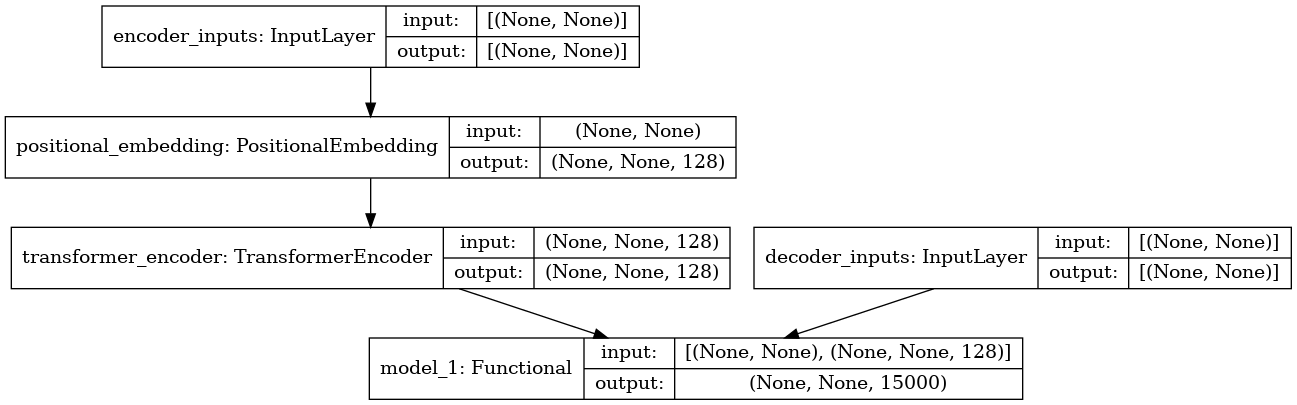

In [12]:
embed_dim  = 128
latent_dim = 1024
num_heads  = 10

#-------------------------------------------------------------------------------
# L1
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
# L3, L4, L5
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

#-------------------------------------------------------------------------------
# From L6 to L10
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
# Encoder
encoder         = keras.Model(encoder_inputs, encoder_outputs)

#-------------------------------------------------------------------------------
# L2
decoder_inputs     = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
# L10
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
# L3, L4, L5
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# From L11 to L16
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

#-------------------------------------------------------------------------------
# Output Probabilities
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

#-------------------------------------------------------------------------------
# Decoder
decoder         = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

#-------------------------------------------------------------------------------
# My Transformer
my_transformer = keras.Model(
                          [encoder_inputs, decoder_inputs], 
                          decoder_outputs, name="my_transformer")

# The model’s summary() method displays all the model’s layers
print(my_transformer.summary())

# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(my_transformer, show_shapes=True)

In [13]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 6.8 MB/s            
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.14.0
    Uninstalling tensorflow-addons-0.14.0:
      Successfully uninstalled tensorflow-addons-0.14.0


In [16]:
# Optimizer
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(
        learning_rate = 0.001, weight_decay=0.0001)

# Compiling the model
my_transformer.compile(loss="sparse_categorical_crossentropy", 
                       optimizer = optimizer, metrics = ["accuracy"])

# Training the model 
epochs = 10 # You have to train it longer to converge
history = my_transformer.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/10
1488/1488 [==============================] - 82s 53ms/step - loss: 1.0835 - accuracy: 0.4876 - val_loss: 0.7908 - val_accuracy: 0.5860
Epoch 2/10
1488/1488 [==============================] - 77s 52ms/step - loss: 0.7683 - accuracy: 0.6024 - val_loss: 0.6335 - val_accuracy: 0.6458
Epoch 3/10
1488/1488 [==============================] - 77s 52ms/step - loss: 0.6230 - accuracy: 0.6569 - val_loss: 0.5697 - val_accuracy: 0.6700
Epoch 4/10
1488/1488 [==============================] - 77s 52ms/step - loss: 0.5389 - accuracy: 0.6893 - val_loss: 0.5341 - val_accuracy: 0.6881
Epoch 5/10
1488/1488 [==============================] - 77s 52ms/step - loss: 0.4830 - accuracy: 0.7116 - val_loss: 0.5174 - val_accuracy: 0.6962
Epoch 6/10
1488/1488 [==============================] - 77s 52ms/step - loss: 0.4451 - accuracy: 0.7275 - val_loss: 0.5100 - val_accuracy: 0.7016
Epoch 7/10
1488/1488 [==============================] - 77s 52ms/step - loss: 0.4168 - accuracy: 0.7407 - val_loss: 0.5087 -

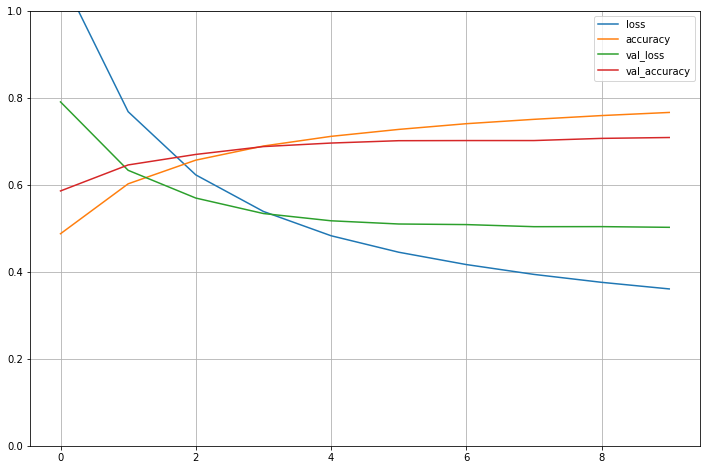

186/186 [==============================] - 7s 34ms/step - loss: 0.5018 - accuracy: 0.7107
Loss     :  0.5018352270126343
accuracy :  0.7107044458389282


In [17]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
test_dataset   = make_dataset(test_pairs)
model_evaluate = my_transformer.evaluate(test_dataset)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

In [18]:
#-------------------------------------------------------------------------------
fr_vocab = fr_vectorization.get_vocabulary()
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
max_decoded_sentence_length = 20

#-------------------------------------------------------------------------------
def decode_sequence(input_sentence):
    tokenized_input_sentence = en_vectorization([input_sentence])

    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fr_vectorization([decoded_sentence])[:, :-1]
        predictions = my_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

#-------------------------------------------------------------------------------
test_en_texts = [pair[0] for pair in test_pairs]
exp = 0
for i in range(30):
    input_sentence = random.choice(test_en_texts)
    translated = decode_sequence(input_sentence)
    print("Example : ",exp)
    print("En: ",test_en_texts[i])

    translated = translated.replace("[start]", "")
    translated = translated.replace("[UNK]", "")
    translated = translated.replace("end", "")
    print("SPN: ",translated)
    exp = exp + 1
    print("-------------------------------------------------------------------")

Example :  0
En:  he came into a fortune when his father died
SPN:   no soy capaz de hacerlo por mí solo            
-------------------------------------------------------------------
Example :  1
En:  where are we going next
SPN:   ¿tom parece que te parece decir              
-------------------------------------------------------------------
Example :  2
En:  issue this order to your employees
SPN:   ¿qué mundo ¿qué es eso               
-------------------------------------------------------------------
Example :  3
En:  i found it difficult to get along with him
SPN:   no creo que sea que sea todo lo que yo sea         
-------------------------------------------------------------------
Example :  4
En:  because of the problem of air pollution the bicycle may some day replace the automobile
SPN:   pensé que tom sería diferente               
-------------------------------------------------------------------
Example :  5
En:  does anyone in your family play the piano
SPN:   a su 